# EECS 491 - A2 - E2
### Tristan Maidment - tdm47

## Goal

The goal of this notebook is to create a hierarchical probablistic model from a dataset of computer specifications.  I want to be able to determine the affect of "speed" on the computer price.  Speed in the dataset is defined as a integer, higher being better.  Due to the arbitrary nature at which speed is defined, I am going to stratify the data by RAM amount.  Generally speaking, computers with more RAM generally are paired with faster processors and as a result, cost more.

## Methodology

An obvious solution to the problem would be to apply a linear regression to the entire data set, where R represents the RAM value:

$$ PRICE_{R} = \alpha + \beta*SPEED_{R} + \epsilon $$

This would provide us with independent linear regressions for each amount of RAM.  However, there are other components in computers, such as hard drive, battery, etc, that directly influence the price.  For that reason, independent regressions for each value of RAM would be biased toward the group average, and not the overall average.  To solve this problem, we will find the group distributions, and the overall distribution from that data.

The answer to this question is to use Partial Pooling, a form of hierarchical linear regression.  It uses the same equation for linear regression as defined above, but replaces `alpha (intercept)` and `beta (slope)` with a gaussian distribution of each value of RAM's intercept and slope.  That allows for an independent parameter for each value of RAM.

Using these individual parameters, we can find the group mean and variance of each RAM amount without biasing towards a specific amount, due to unequal distributions of data.

Data from: `https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/Ecdat/Computers.csv`

Adapted from:
`http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/`

## Implementation

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import theano
import math

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In order to implement Partial Pooling, the unique RAM values need to be found for stratification. In addition, I define `ram_idx`, which will be used to input the RAM distributions into the `alpha` and `beta` distributions.

In [2]:
#load in data 
data = pd.read_csv('./computers.csv')

# make a sorted list of all possible RAM amounts
ram = np.sort(data.ram.unique())

# number of unique ram configurations 
n = len(ram)

# make a list of indices corresponding to different configurations
#this is for the linear regression
idx = np.arange(0, n)

# create an ordered list with the indices 
ram_idx = data.ram.replace(ram, idx)

# lower the complexity of the price due to sampling complexity
data.price = np.floor(data.price.astype(float)/100).astype(int)


The structure of the data being used for this exercise can be seen below:

In [3]:
data[['price', 'speed', 'ram']].head()

,price,speed,ram
0,14,25,4
1,17,33,2
2,15,25,4
3,18,25,8
4,32,33,16


### Model Definition
The model defines two Gaussian curves `mu_a` and `mu_b`.  These curves represent the **distribution of averages** of the linear regressions for each subset of RAM.  In addition, we need to define the **distribution of standard deviations**.  Since standard deviations tend to be closer to 0 and always positive, a Half Normal distribution is a good way to fit the variance.

The values for `alpha` and `beta` are then defined, and use the previously defined mean and standard deviation distributions.  The `epsilon` distribution (offset) is then defined.  We can assume that the offset is positive (and therefor a HalfNormal can be used) due to the fact that there is no values in the data set.

`speed_est` is defined using the linear regression equation previously stated. 

`a (alpha)` is a vector with one distribution per RAM value.  The syntax is effectively `a = [ram_2, ram_4, ram_8, ...]`, where, for instance, `ram_2 = [0, 0, 0, 0, ...]`.  However, in order to do this, we must resize the vector, which is done with the syntax `a[0, 0, 0, 0, ..., 1, 1, 1, ..., 2, 2, ...]`.  Knowing this, we can input the data, and resize the vector by simply inputting entire data set, `ram_idx`.  This will result in `a` contain 6 distinct distributions, one for each value of ram.  The same applies for `b`.

*Each distribution defined within a is considered a `subtensor`, as `a` is defined as a `tensor`.*

The speed likelihood distribution `speed_like` is defined as well, using `speed_est` as the mean.  We will be sampling on this distribution.

This model is now able to do a partial pooled linear regression for each value of ram in the dataset.  

In [4]:
with pm.Model() as model:

    # distribution of means
    mu_a = pm.Normal('mu_a', mu = 0., sd = 1000)
    mu_b = pm.Normal('mu_b', mu = 0., sd = 1000)
    
    # distribution of standard deviation
    sigma_a = pm.HalfNormal('sigma_a', sd = 100)
    sigma_b = pm.HalfNormal('sigma_b', sd = 100)
    
    # definition of A and B
    a = pm.Normal('a', mu = mu_a, sd = sigma_a, shape = n) # intercept prior
    b = pm.Normal('b', mu = mu_b, sd = sigma_b, shape = n) # slope prior
    
    # distribution for the epsilon term (distribution of likelhood standard deviation)
    epsilon = pm.HalfNormal('eps', 5)
        
    # linear regression
    speed_est = a[ram_idx] + b[ram_idx] * data.speed
    
    # likelihood
    speed_like = pm.Normal('speed', mu = speed_est, sd = epsilon, observed = data.price)

### Sampling
The next step is the use the NUTS sampler to determine approximations of the various distributions in the data.  The sampler takes a specified amount of samples of the model and returns the distributions for each varible defined.  Due to the limitations of my laptop, I used 2000 draws and 1000 initializer draws.

In [5]:
with model:
    trace = pm.sample(draws=2000, n_init=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, b, a, sigma_b_log__, sigma_a_log__, mu_b, mu_a]
100%|██████████| 2500/2500 [04:24<00:00,  9.44it/s]
The acceptance probability does not match the target. It is 0.8797354570885143, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


## Analysis 

From the trace, we can see the effects of RAM and proccesor speed on price.  We can see that the group average `mu_a` price (divided by a factor of 100, so approximately \$2500).  `mu_b` indicates that there is a positive correlation between RAM amount and computer price.

The most interesting comes from `a` and `b`.  We can see the distributions for each value of ram (although I don't know which color corresponds with each).

The width, or rather lack of, depicts the confidence of each distribution.  Therefore, we can see that the orange distribution has a lot of variance in the data.  A non-pooling model would have taken the average of the data.  However, partial pooling will weight that data much lower when calculating the group averages, due to the variability of the data.

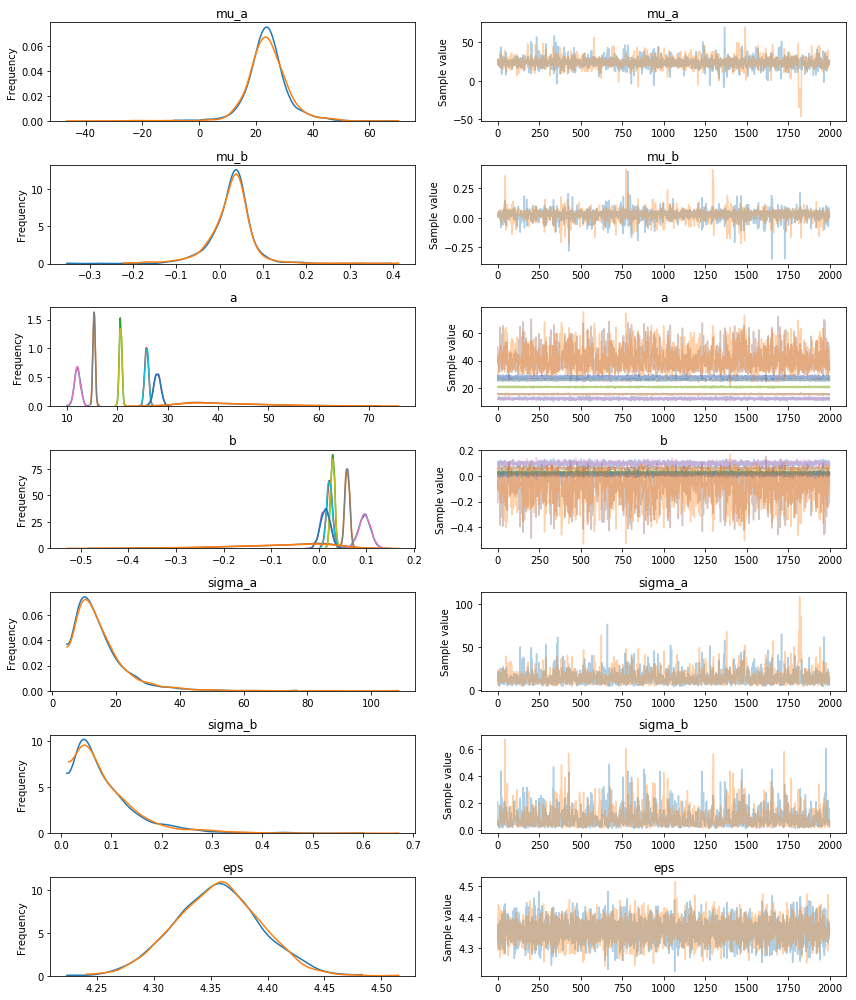

In [6]:
pm.traceplot(trace);